# Data Preparation

The satellite image used in this chapter is provided by the Planet company. Planet company has an [Education and Research Program](https://www.planet.com/markets/education-and-research/) that provides limited, non-commercial access to PlanetScope imagery. The product used in this chapter is the Planet orthorectified product `PS2`, which includes four bands, blue (Band 1, 455-515 nm), green (Band 2, 500-590 nm), red (Band 3, 590-670 nm), and near-infrared (Band4, 780-860 nm). The spatial resolution of the image is 3.7 meters. As a first step, we visualize and inspect the Planet data. The following block of code reads the Planet image over a region in California and plots the results. 


In [16]:
from huggingface_hub import hf_hub_download

repo_id = "geosmart/scm_geosmart_use_case"
raster_file = "data/planet/20180528_181110_1025_3B_AnalyticMS_SR_clip.tif"
sample_100k_file = "./data/samples/sample_100K.csv"
cache_dir = "."

dir_raster = hf_hub_download(repo_id=repo_id, filename=raster_file, cache_dir=cache_dir, repo_type="dataset")
dir_sample_100k = hf_hub_download(repo_id=repo_id, filename=sample_100k_file, cache_dir=cache_dir, repo_type="dataset")


(…)28_181110_1025_3B_AnalyticMS_SR_clip.tif:   0%|          | 0.00/66.4M [00:00<?, ?B/s]

data/samples/sample_100K.csv:   0%|          | 0.00/2.96M [00:00<?, ?B/s]

In [20]:
# https://stackoverflow.com/questions/53581278/test-if-notebook-is-running-on-google-colab
def is_running_on_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

IN_COLAB = is_running_on_colab()

if IN_COLAB:
    !wget https://raw.githubusercontent.com/geo-smart/scm_geosmart_use_case/main/book/chapters/functions_book_chapter_SCA.py

if IN_COLAB:
    %pip install rasterio
    %pip install pandas

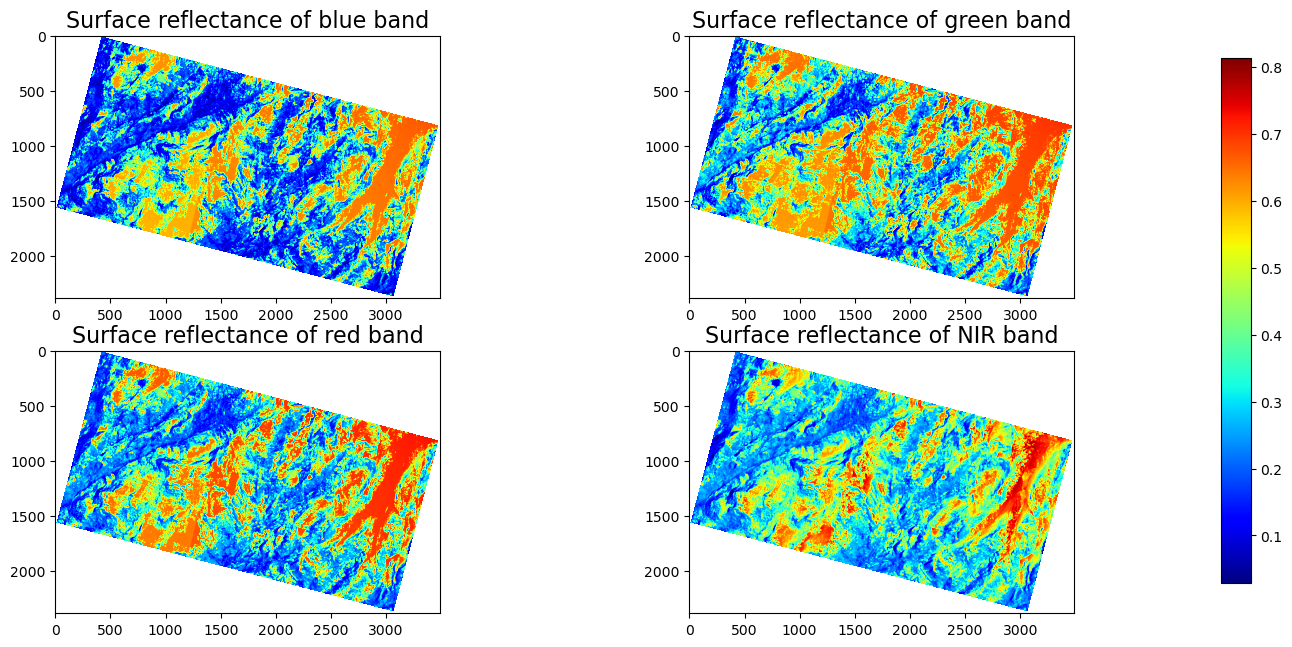

In [18]:
# import functions and packages
from functions_book_chapter_SCA import *
import rasterio

planet = rasterio.open(dir_raster).read()/10000
planet = np.where(planet[0,:,:] == 0, np.nan, planet) # the default nan data value is 0, replace with np.nan

fig, axs = plt.subplots(2,2,figsize=(15,7.5))
im1 = axs[0,0].imshow(planet[0,:,:],cmap='jet')
axs[0,0].set_title("Surface reflectance of blue band", fontsize=16)

im2 = axs[0,1].imshow(planet[1,:,:], cmap='jet')
axs[0,1].set_title("Surface reflectance of green band", fontsize=16)

im3 = axs[1,0].imshow(planet[2,:,:], cmap='jet')
axs[1,0].set_title("Surface reflectance of red band", fontsize=16)

im4 = axs[1,1].imshow(planet[3,:,:], cmap='jet')
axs[1,1].set_title("Surface reflectance of NIR band", fontsize=16)

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax)

The figure above shows the surface reflectance of the four bands in the PlanetScope image `20180528_181110_1025_3B_AnalyticMS_SR_clip.tif` within a region of the Tuolumne Basin, California. The red and orange colors represent high surface reflectance, while the cyan and dark blue colors represent low surface reflectance. Because snow has a very high reflectance in the visible bands, those red and orange regions are very likely to be covered by snow.

In the next step, we carefully drew a few ROIs (i.e., Region of Interest) on the image and labeled each ROI as ‘1’ or ‘0’. ‘1’ represents ‘snow’, while ‘0’ represents ‘no-snow’. We label the ROIs based on visual inspection. We only considered the binary classification because the mixing pixel issue is not significant for the Planet image at such a high spatial resolution (3.7 meter), even though it is also not negligible, especially at the edge of snowpack and no-snow land surface. For the demonstration purpose, we will only show the binary classification, “snow” and “no-snow” in this chapter.
We extracted the surface reflectance of all bands of each pixel inside the ROIs and generated an input feature table with 100,000 samples (i.e., ‘sample_100K.csv’). Here, one pixel is equivalent to one sample. Each sample has four feature columns (blue, green, red, and nir) and one label column (label). In Section 4, we will discuss the influence of sample size on model performance. 


In [19]:
# read model input features and labels 
import pandas as pd

data = pd.read_csv(dir_sample_100k, index_col = False)
print("Sample dimentions:".format(), data.shape)
print(data.head())
X = data[['blue','green','red','nir']]
y = data['label']

Sample dimentions: (100000, 5)
     blue   green     red     nir  label
0  0.5948  0.4274  0.6514  0.6841      1
1  0.1088  0.1296  0.1580  0.2639      0
2  0.7735  0.5578  0.8296  0.7552      1
3  0.1581  0.1793  0.2152  0.2700      0
4  0.5916  0.4253  0.6499  0.6401      1


* `blue`: The surface reflectance of the blue band (455-515 nm). Surface reflectance is the fraction of incoming solar radiation that is reflected further from the Earth's surface. It typically ranges from 0 to 1. The original surface reflectance value extracted from the Planet ‘PS2’ product is scaled by 10,000. Here, we have transferred the original values to real surface reflectance as shown in the table.

* `green`: The surface reflectance of the green band (500-590 nm). 

* `red`: The surface reflectance of the red band (590-670 nm). 

* `nir`: The surface reflectance of the near-infrared band (780-860 nm).

* `label`: '0' is no-snow land surface, '1' is snow surface. 
